In [75]:
import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator  # For MPS Simulator.

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from adaptvqe.pools import DVG_CEO
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt

In [76]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

In [77]:
mol = pyscf.gto.Mole()
geom = of.chem.geometry_from_pubchem("H2")
basis = "sto-3g"
symmetry = "C2v"
multiplicity = 1
charge = 0
mol.build(
    atom=geom,
    basis=basis,
    symmetry=symmetry,
)

In [78]:
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())

In [79]:
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -1.06610864931794
CASCI E = -1.10115033023262  E(CI) = -1.63032754115262  S^2 = 0.0000000


In [80]:
exact_energy

np.float64(-1.1011503302326182)

## Get the Ansatz circuit

In [81]:
mol_of = MolecularData(geom, basis, multiplicity, charge, description='H2')
mol_of = run_pyscf(mol_of, run_fci=True, run_ccsd=True)
nelec = (num_elec_a, num_elec_b)
print(mol_of.n_orbitals)

2


In [82]:
pool = DVG_CEO(mol_of)

my_adapt = LinAlgAdapt(
    pool=pool,
    molecule=mol_of,
    max_adapt_iter=1,
    recycle_hessian=True,
    tetris=True,
    verbose=True,
    threshold=0.1,
)

my_adapt.run()
data = my_adapt.data


linalg_adapt prepared with the following settings:
> Pool: DVG_CEO
> Molecule: H2 (interatomic distance r=0Å)
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: True
> Tetris: True (progressive optimization: False)
> Convergence threshold (gradient norm):  0.1
> Maximum number of iterations:  1
> candidates per iteration:  1

Initial energy: -1.0661086493179361

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 6 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 2: 0.39358116697094037
Operator 4: 0.39358116697094037
Operator 5: 0.39358116697094037
Total gradient norm: 0.5566078242249335
Operators under consideration (3):
[2, 4, 5]
Corresponding gradients (ordered by magnitude):
[np.float64(0.39358116697094037), np.float64(0.39358116697094037), np.float64(0.39358116697094037)]

Adding OVP-CEO.
Operator(s) added to ansatz: [4]

Screening operators with disjoint supports...
None 

In [83]:
ansatz_circuit = pool.get_circuit(data.result.ansatz.indices, data.result.ansatz.coefficients)
# Prepare the HF reference state, then add the Ansatz circuit.
q = QuantumRegister(2 * num_orbitals)
circuit = QuantumCircuit(q)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
circuit = circuit.compose(ansatz_circuit)
circuit.measure_all()
print(circuit)

        ┌──────────────────┐┌───┐┌───┐                          »
 q29_0: ┤0                 ├┤ X ├┤ H ├──────────────────────────»
        │                  │└─┬─┘├───┤┌───┐                ┌───┐»
 q29_1: ┤1                 ├──┼──┤ X ├┤ H ├────────────────┤ X ├»
        │  Hartree_fock_jw │  │  └─┬─┘└───┘┌──────────────┐└─┬─┘»
 q29_2: ┤2                 ├──■────┼────■──┤ Ry(0.088109) ├──■──»
        │                  │       │  ┌─┴─┐└──────────────┘     »
 q29_3: ┤3                 ├───────■──┤ X ├─────────────────────»
        └──────────────────┘          └───┘                     »
meas: 4/════════════════════════════════════════════════════════»
                                                                »
«                         ┌───┐  ┌──────────┐  ┌──────────┐                 »
« q29_0: ─────────────────┤ X ├──┤ Ry(-π/2) ├──┤ Rz(-π/2) ├─────────────────»
«                         └─┬─┘  └──────────┘  └──┬───┬───┘      ┌───┐      »
« q29_1: ───────────────────┼───────────

In [84]:
nq = circuit.num_qubits
print(f"Circuit has {nq} qubits.")

Circuit has 4 qubits.


## Sample shots from the circuit

In [85]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
to_run = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'rz': 21, 'cx': 19, 'sx': 15, 'measure': 4, 'x': 2, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 21, 'cx': 19, 'sx': 15, 'measure': 4, 'x': 2, 'barrier': 2})


In [86]:
# Get the HF state for visualizing results.
q = QuantumRegister(2 * num_orbitals)
hf = QuantumCircuit(q)
hf.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
hf.measure_all()
hf = pass_manager.run(hf)

simulator = AerSimulator(method="matrix_product_state")
result = simulator.run(hf, shots=1)
hf_bitstring = list(result.result().get_counts().keys())[0]
hf_bitstring

'0101'

# Get counts

In [87]:
job = sampler.run([to_run], shots=30_000)

In [88]:
bit_array = job.result()[0].data.meas

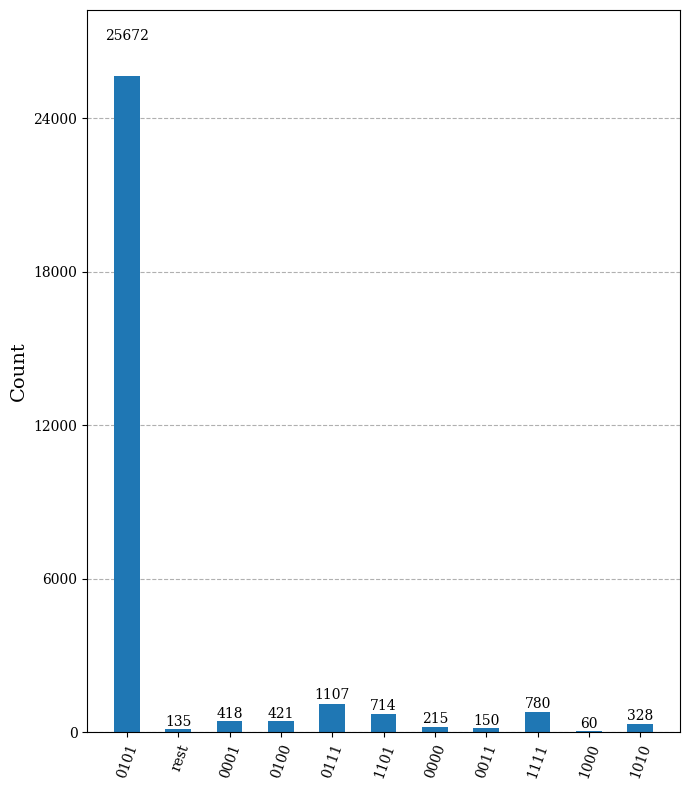

In [89]:
qiskit.visualization.plot_histogram(
    bit_array.get_counts(),
    target_string=hf_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    # ax=ax
    # filename="hf_ucj2.pdf",
)
# plt.tight_layout()
# plt.savefig("hf_ucj1.pdf")